In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pybamm
from parameters_NMC import parameter_values

## Parameter values
Here we display the parameter values and plot the functional form of selected parameters.

In [39]:
# table of parameters
pd.DataFrame.from_dict(parameter_values._dict_items, columns=["Value"], orient="index")

,Value
1 + dlnf/dlnc,1.0
Ambient temperature [K],298.15
Cation transference number,0.2594
Cell cooling surface area [m2],0.037857
Cell volume [m3],0.000128
...,...
Separator thickness [m],0.00002
Total heat transfer coefficient [W.m-2.K-1],10.0
Typical current [A],12.5
Typical electrolyte concentration [mol.m-3],1000.0


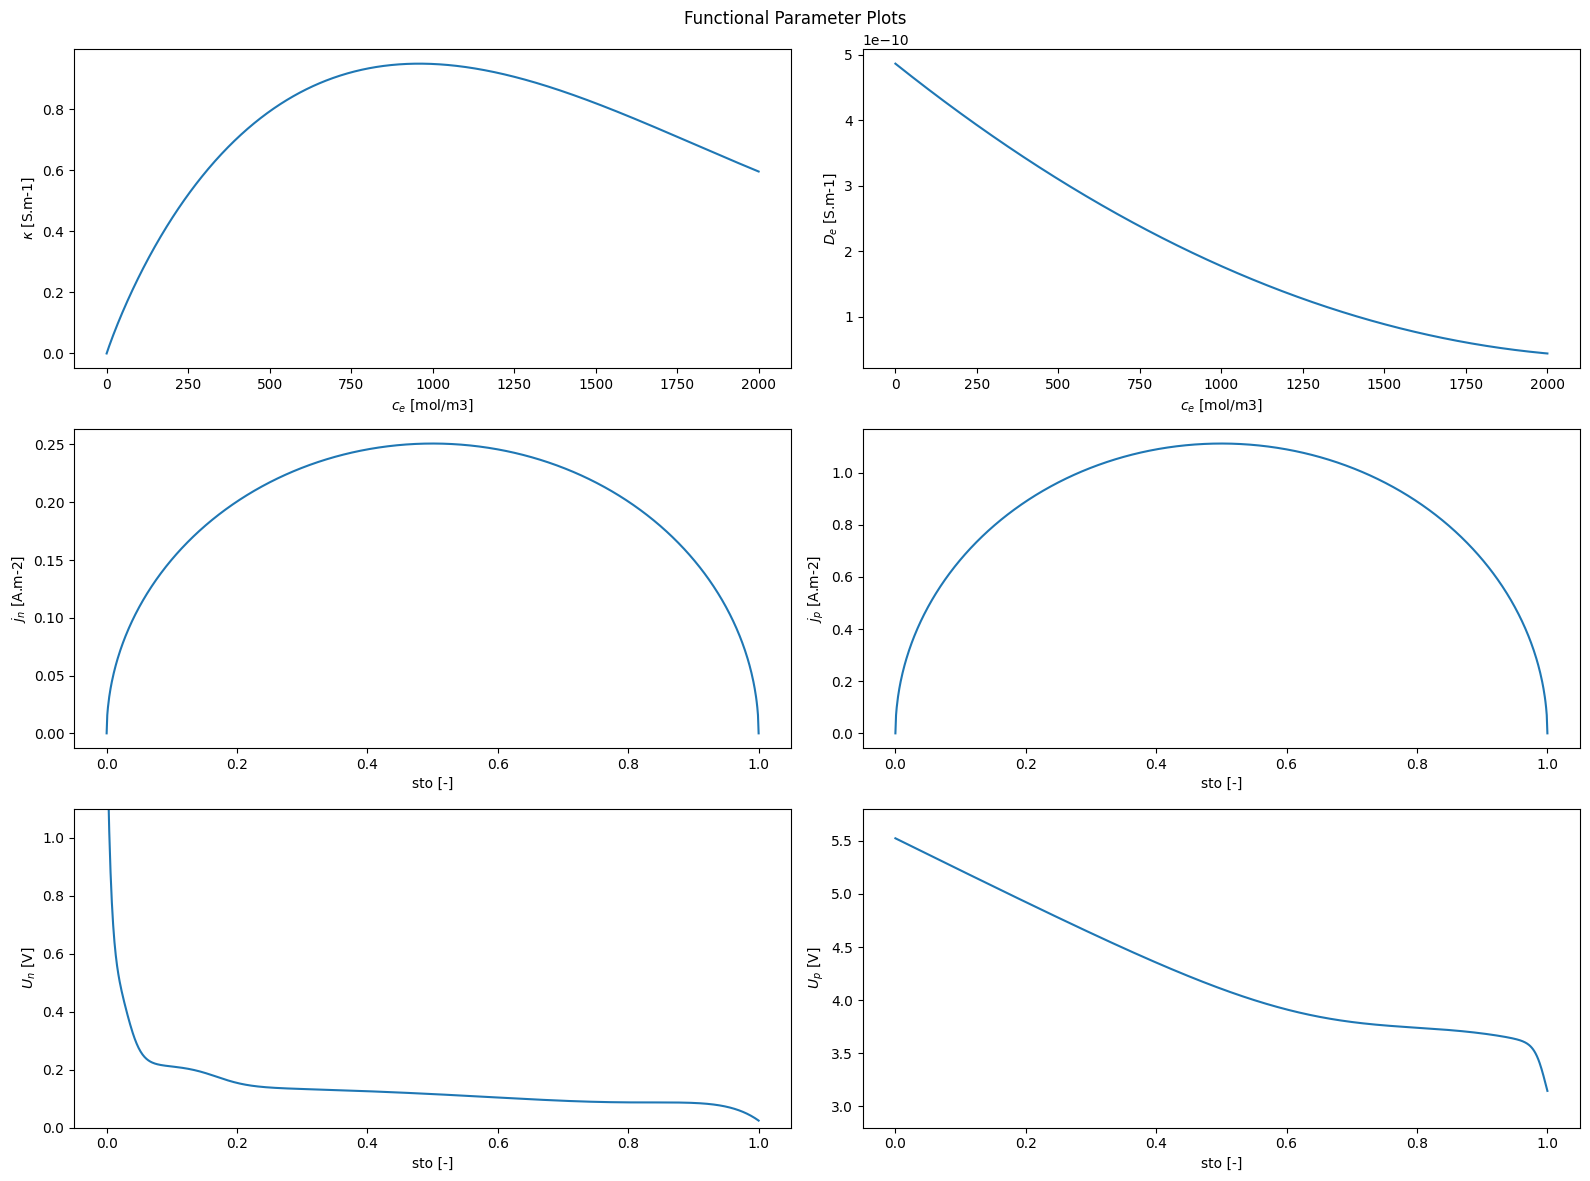

In [40]:
# plot some parameters as a function of sto/concentration
x = pybamm.linspace(0, 1, 1000)
c_n_max = parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
c_n = x * c_n_max
c_p = x * c_p_max
c_e = pybamm.linspace(0, 2000, 1000)
c_e_ref = parameter_values["Typical electrolyte concentration [mol.m-3]"]
T = parameter_values["Reference temperature [K]"]

fig, ax = plt.subplots(3, 2, figsize=(16, 12))
plt.suptitle("Functional Parameter Plots")

ax[0, 0].plot(c_e.entries, parameter_values.evaluate(parameter_values["Electrolyte conductivity [S.m-1]"](c_e, T)))
ax[0, 0].set(xlabel="$c_e$ [mol/m3]", ylabel="$\kappa$ [S.m-1]")
ax[0, 1].plot(c_e.entries, parameter_values.evaluate(parameter_values["Electrolyte diffusivity [m2.s-1]"](c_e, T)))
ax[0, 1].set(xlabel="$c_e$ [mol/m3]", ylabel="$D_e$ [S.m-1]")
ax[1, 0].plot(x.entries, parameter_values.evaluate(parameter_values["Negative electrode exchange-current density [A.m-2]"](c_e_ref, c_n, c_n_max, T)))
ax[1, 0].set(xlabel="sto [-]", ylabel="$j_n$ [A.m-2]")
ax[1, 1].plot(x.entries, parameter_values.evaluate(parameter_values["Positive electrode exchange-current density [A.m-2]"](c_e_ref, c_p, c_p_max, T)))
ax[1, 1].set(xlabel="sto [-]", ylabel="$j_p$ [A.m-2]")
ax[2, 0].plot(x.entries, parameter_values["Negative electrode OCP [V]"](x).entries)
ax[2, 0].set(xlabel="sto [-]", ylabel="$U_n$ [V]")
ax[2, 0].set_ylim([0, 1.1])
ax[2, 1].plot(x.entries, parameter_values["Positive electrode OCP [V]"](x).entries)
ax[2, 1].set(xlabel="sto [-]", ylabel="$U_p$ [V]")
ax[2, 1].set_ylim([2.8, 5.8])

plt.tight_layout()



## Conversions to BPX format

In [41]:
# electrode area
L_y = parameter_values["Electrode width [m]"]
L_z = parameter_values["Electrode height [m]"]
print("Electrode width [m]", L_y)
print("Electrode height [m]", L_z)
print("Electrode area [m]", L_y*L_z)

Electrode width [m] 0.088
Electrode height [m] 0.191
Electrode area [m] 0.016808


In [42]:
# lumped thermal properties - take weighted arithmetic mean

def arithmetic_mean(param):
    p_n = parameter_values["Negative electrode " + param]
    p_s = parameter_values["Separator " + param]
    p_p = parameter_values["Positive electrode " + param]
    L_n = parameter_values["Negative electrode thickness [m]"]    
    L_s = parameter_values["Separator thickness [m]"]    
    L_p = parameter_values["Positive electrode thickness [m]"]
    L = L_n + L_s + L_p
    return (p_n*L_n + p_s*L_s + p_p*L_p) / L

c_p = arithmetic_mean("specific heat capacity [J.kg-1.K-1]")
rho = arithmetic_mean("density [kg.m-3]")
kappa = arithmetic_mean("thermal conductivity [W.m-1.K-1]")

print("specific heat:", c_p)
print("density:", rho)
print("conductivity:", kappa)

specific heat: 912.6832684824903
density: 1847.068638132296
conductivity: 2.0393828793774325


In [43]:
# BET surface area
b_n = 3 * parameter_values["Negative electrode active material volume fraction"] / parameter_values["Negative particle radius [m]"]
b_p = 3 * parameter_values["Positive electrode active material volume fraction"] / parameter_values["Positive particle radius [m]"]

print("BET negative:", b_n)
print("BET positive:", b_p)

BET negative: 499521.8446601941
BET positive: 432071.7391304348


In [44]:
# transport efficiency
eps_n = parameter_values["Negative electrode porosity"]
eps_s = parameter_values["Separator porosity"]
eps_p = parameter_values["Positive electrode porosity"]
print("Negative electrode transport efficiency", eps_n ** 1.5)
print("Separator transport efficiency", eps_s ** 1.5)
print("Positive electrode transport efficiency", eps_p ** 1.5)

Negative electrode transport efficiency 0.1280051644650374
Separator transport efficiency 0.32221576621884906
Positive electrode transport efficiency 0.1461766646374932


In [45]:
# reaction rates
# in pybamm exchange current is defined j0 = k * sqrt(ce * cs * (cs-cs_max))
# in BPX exchange current is defined j0 = F * k_norm * sqrt((ce/ce0) * (cs/cs_max) * (1-cs/cs_max))

c_e = parameter_values["Initial concentration in electrolyte [mol.m-3]"]
F = 96485
c_p_max = parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
c_n_max = parameter_values["Maximum concentration in negative electrode [mol.m-3]"]

j0_50_p = 1.11178673498325
k_p_ref = 2*j0_50_p / c_p_max / np.sqrt(c_e)
k_p_norm = k_p_ref * c_p_max * c_e ** 0.5 / F

j0_50_n = 0.250805067133009
k_n_ref = 2*j0_50_n / c_n_max / np.sqrt(c_e)
k_n_norm = k_n_ref * c_n_max * c_e ** 0.5 / F

print("Negative electrode reaction rate:", k_n_norm)
print("Positive electrode reaction rate:", k_p_norm)


Negative electrode reaction rate: 5.198840589376774e-06
Positive electrode reaction rate: 2.3045794371835e-05


In [46]:
# Confirm reaction rate result
k_n_norm_test= j0_50_n/(F/2)
print(k_n_norm_test)

k_p_norm_test= j0_50_p/(F/2)
print(k_p_norm_test)

5.198840589376774e-06
2.3045794371835e-05
